In [1]:
!pip install layoutparser

In [2]:
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-install-62unu7_0/detectron2_cf39e60694f64260b4e1d66ebaecdc8b
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-62unu7_0/detectron2_cf39e60694f64260b4e1d66ebaecdc8b
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578


In [3]:
!pip install layoutparser[ocr]

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_file_image = "data/resumes/temp/images_resumes_105.pdf/1_105.jpeg"

image = cv2.imread(path_file_image)
#image = image[..., ::-1]

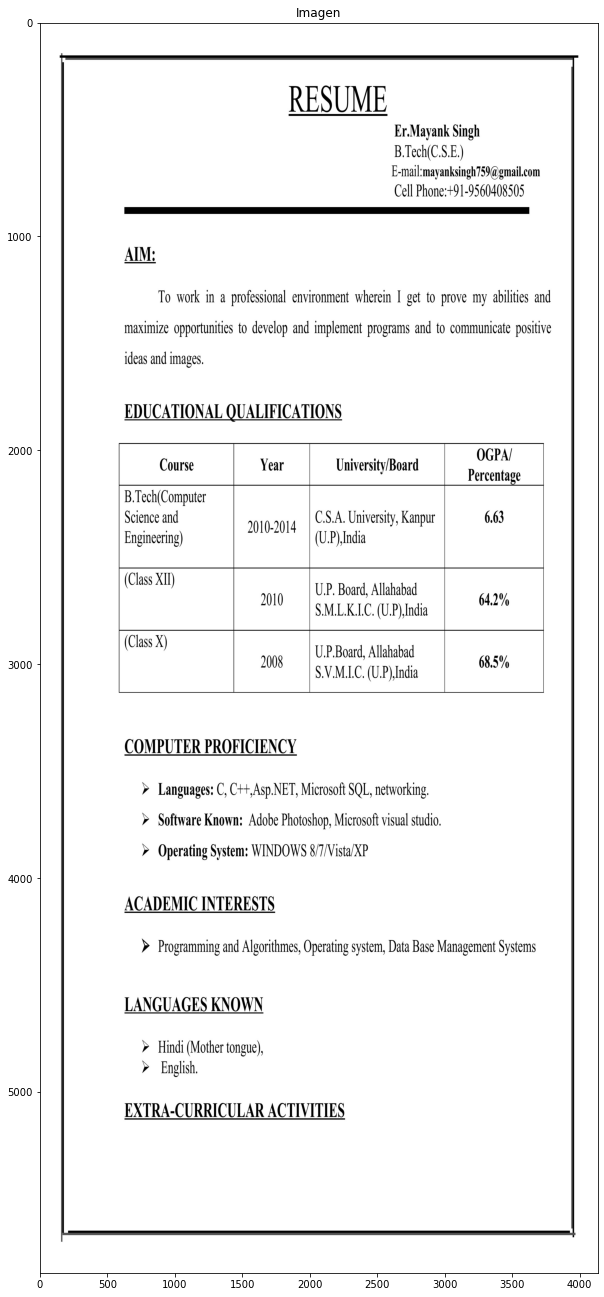

In [5]:
fig = plt.figure()
fig.set_size_inches(10,23)
plt.title('Imagen')
plt.imshow(image, cmap='gray', aspect='auto') 
plt.show()

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensor

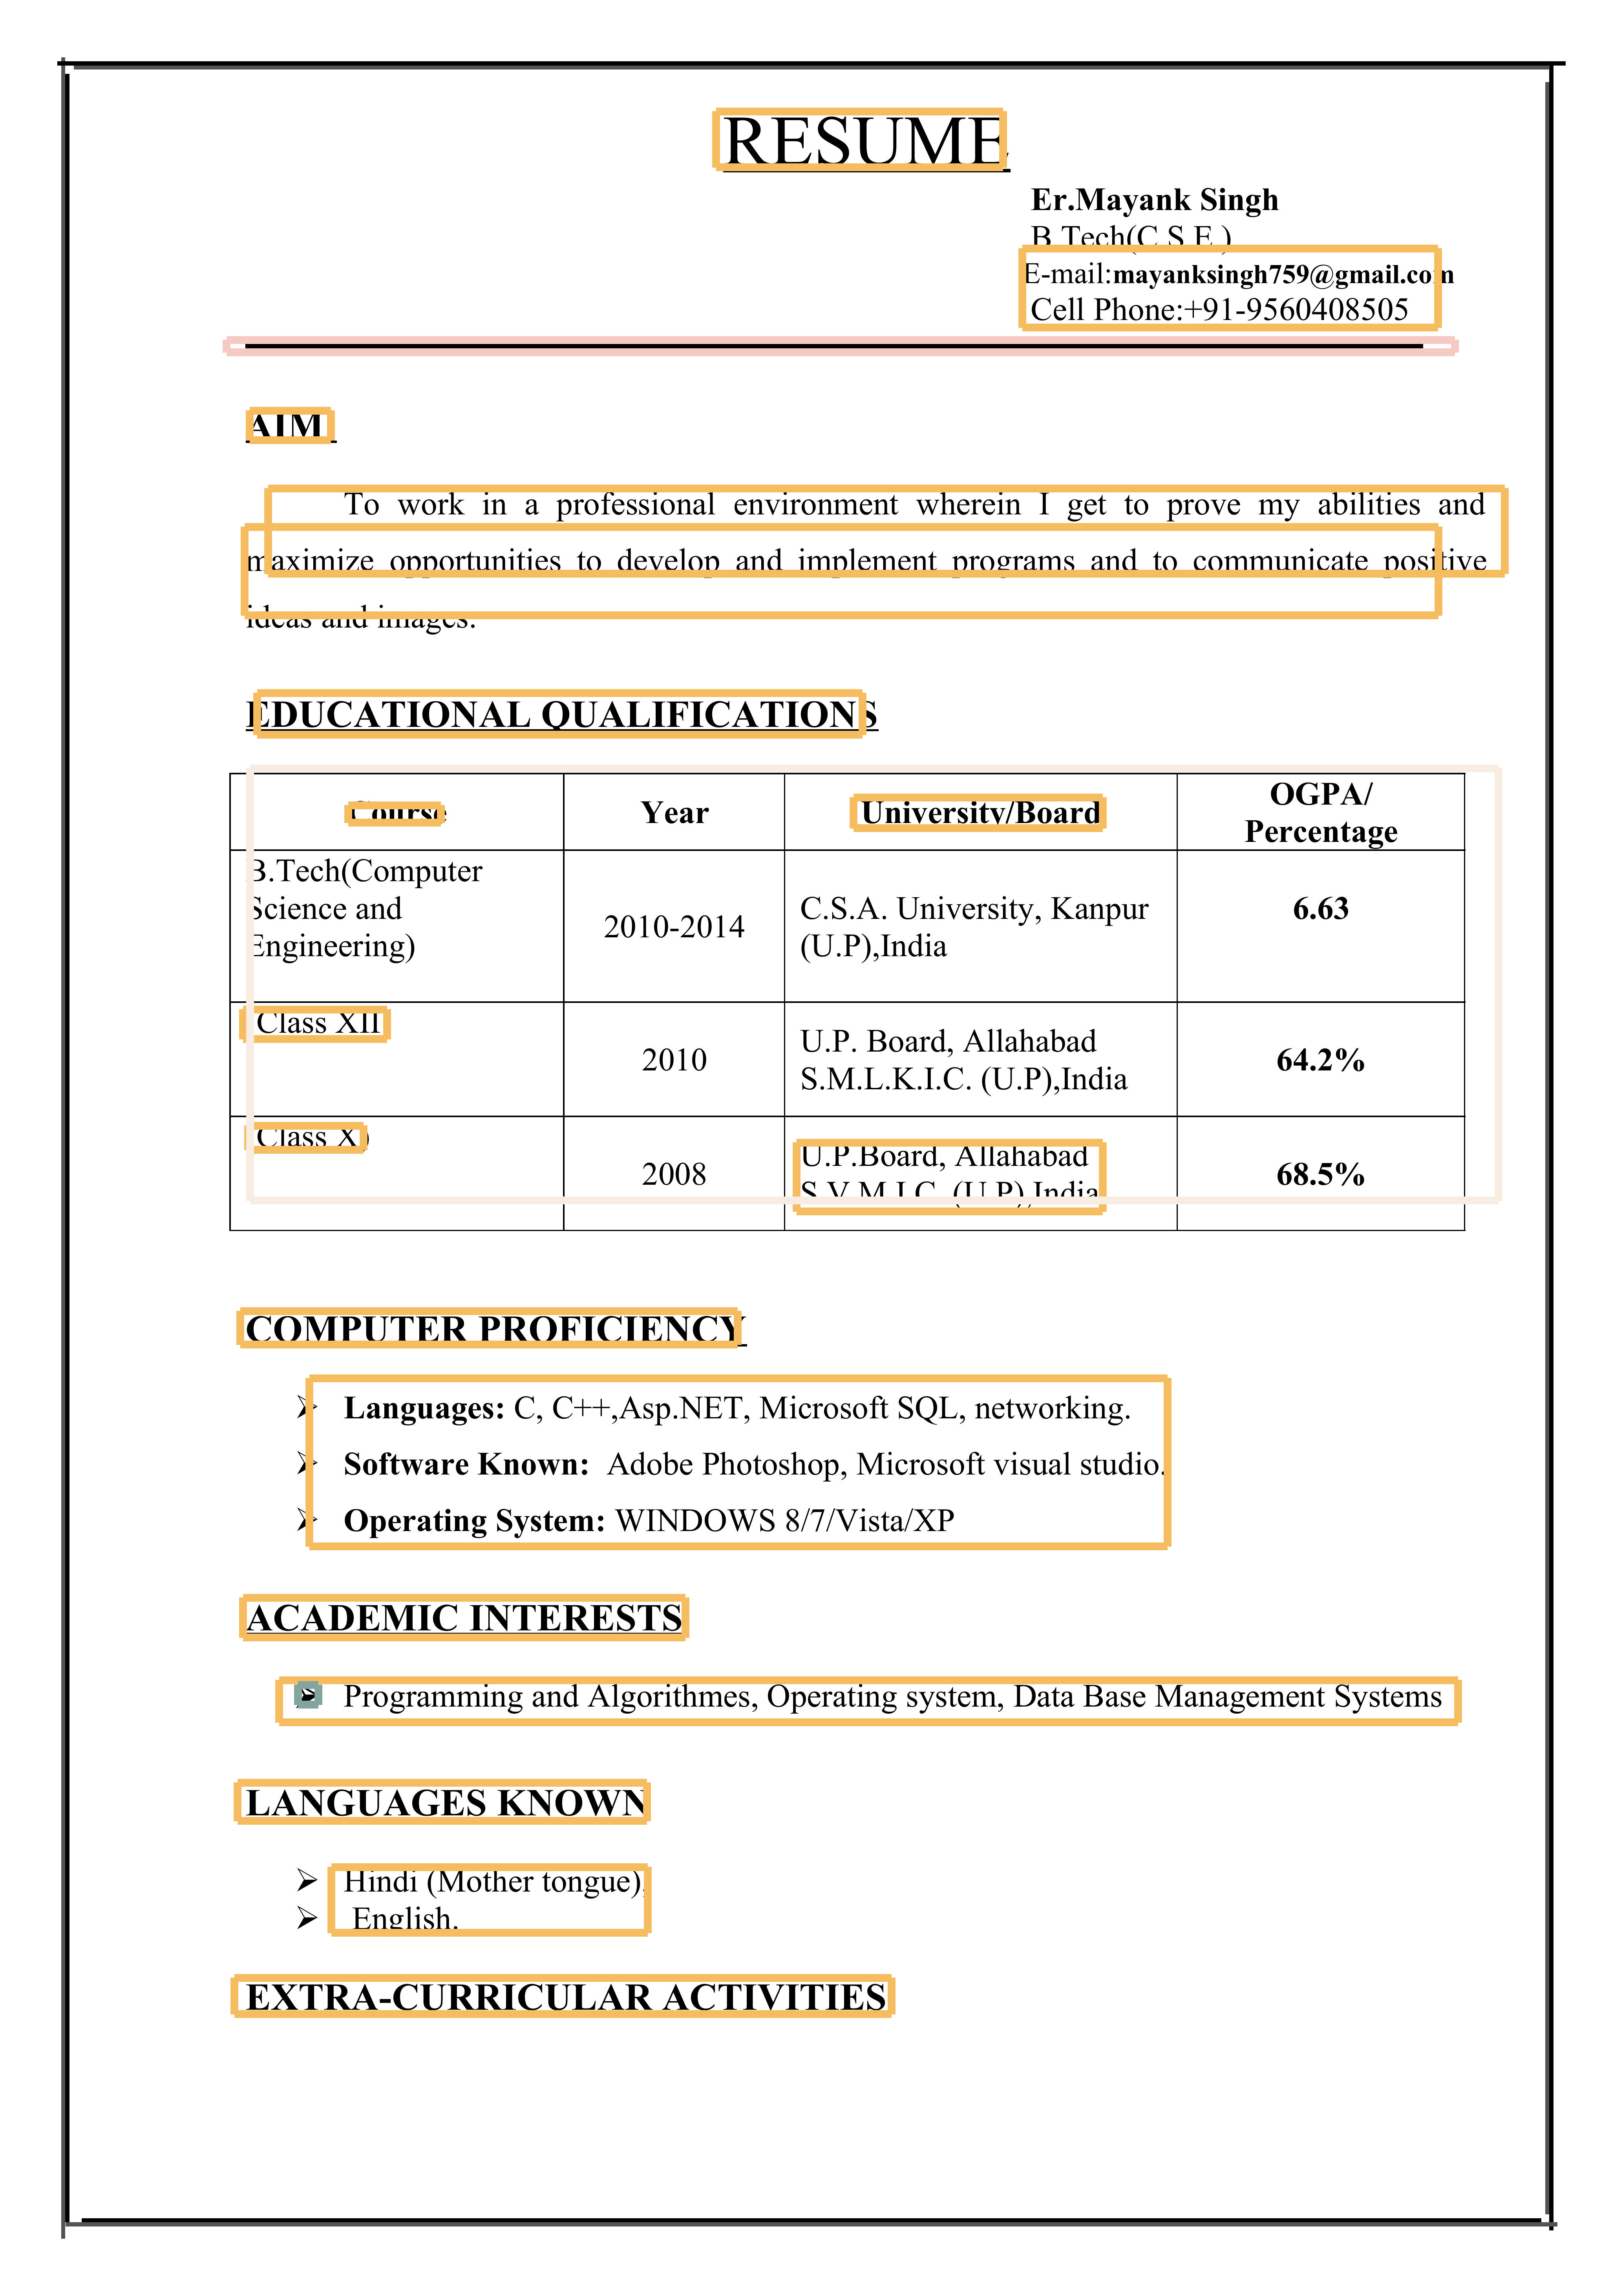

In [6]:
import layoutparser as lp

model = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
     label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [7]:
text_blocks = lp.Layout([b for b in layout if b.type=="TextRegion"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=683.744384765625, y_1=1243.4248046875, x_2=3832.66455078125, y_2=1461.5013427734375), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9999076128005981), TextBlock(block=Rectangle(x_1=1824.5631103515625, y_1=283.1886291503906, x_2=2554.537109375, y_2=426.3751525878906), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9998611211776733), TextBlock(block=Rectangle(x_1=788.755126953125, y_1=3509.299560546875, x_2=2973.021240234375, y_2=3938.14794921875), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9998207688331604), TextBlock(block=Rectangle(x_1=711.4645385742188, y_1=4278.31982421875, x_2=3713.112060546875, y_2=4386.580078125), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9993996620178223), TextBlock(block=Rectangle(x_1=636.1734619140625, y_1=1045.2470703125, x_2=842.0537109375, y_2=1121.0286865234375), text=None, id=None, type=TextRegion, parent=None, ne

In [8]:
figure_blocks = lp.Layout([b for b in layout if b.type=='TableRegion'])
figure_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=637.8055419921875, y_1=1956.4617919921875, x_2=3816.190673828125, y_2=3057.944091796875), text=None, id=None, type=TableRegion, parent=None, next=None, score=0.8479415774345398)], page_data={})

In [9]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [10]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

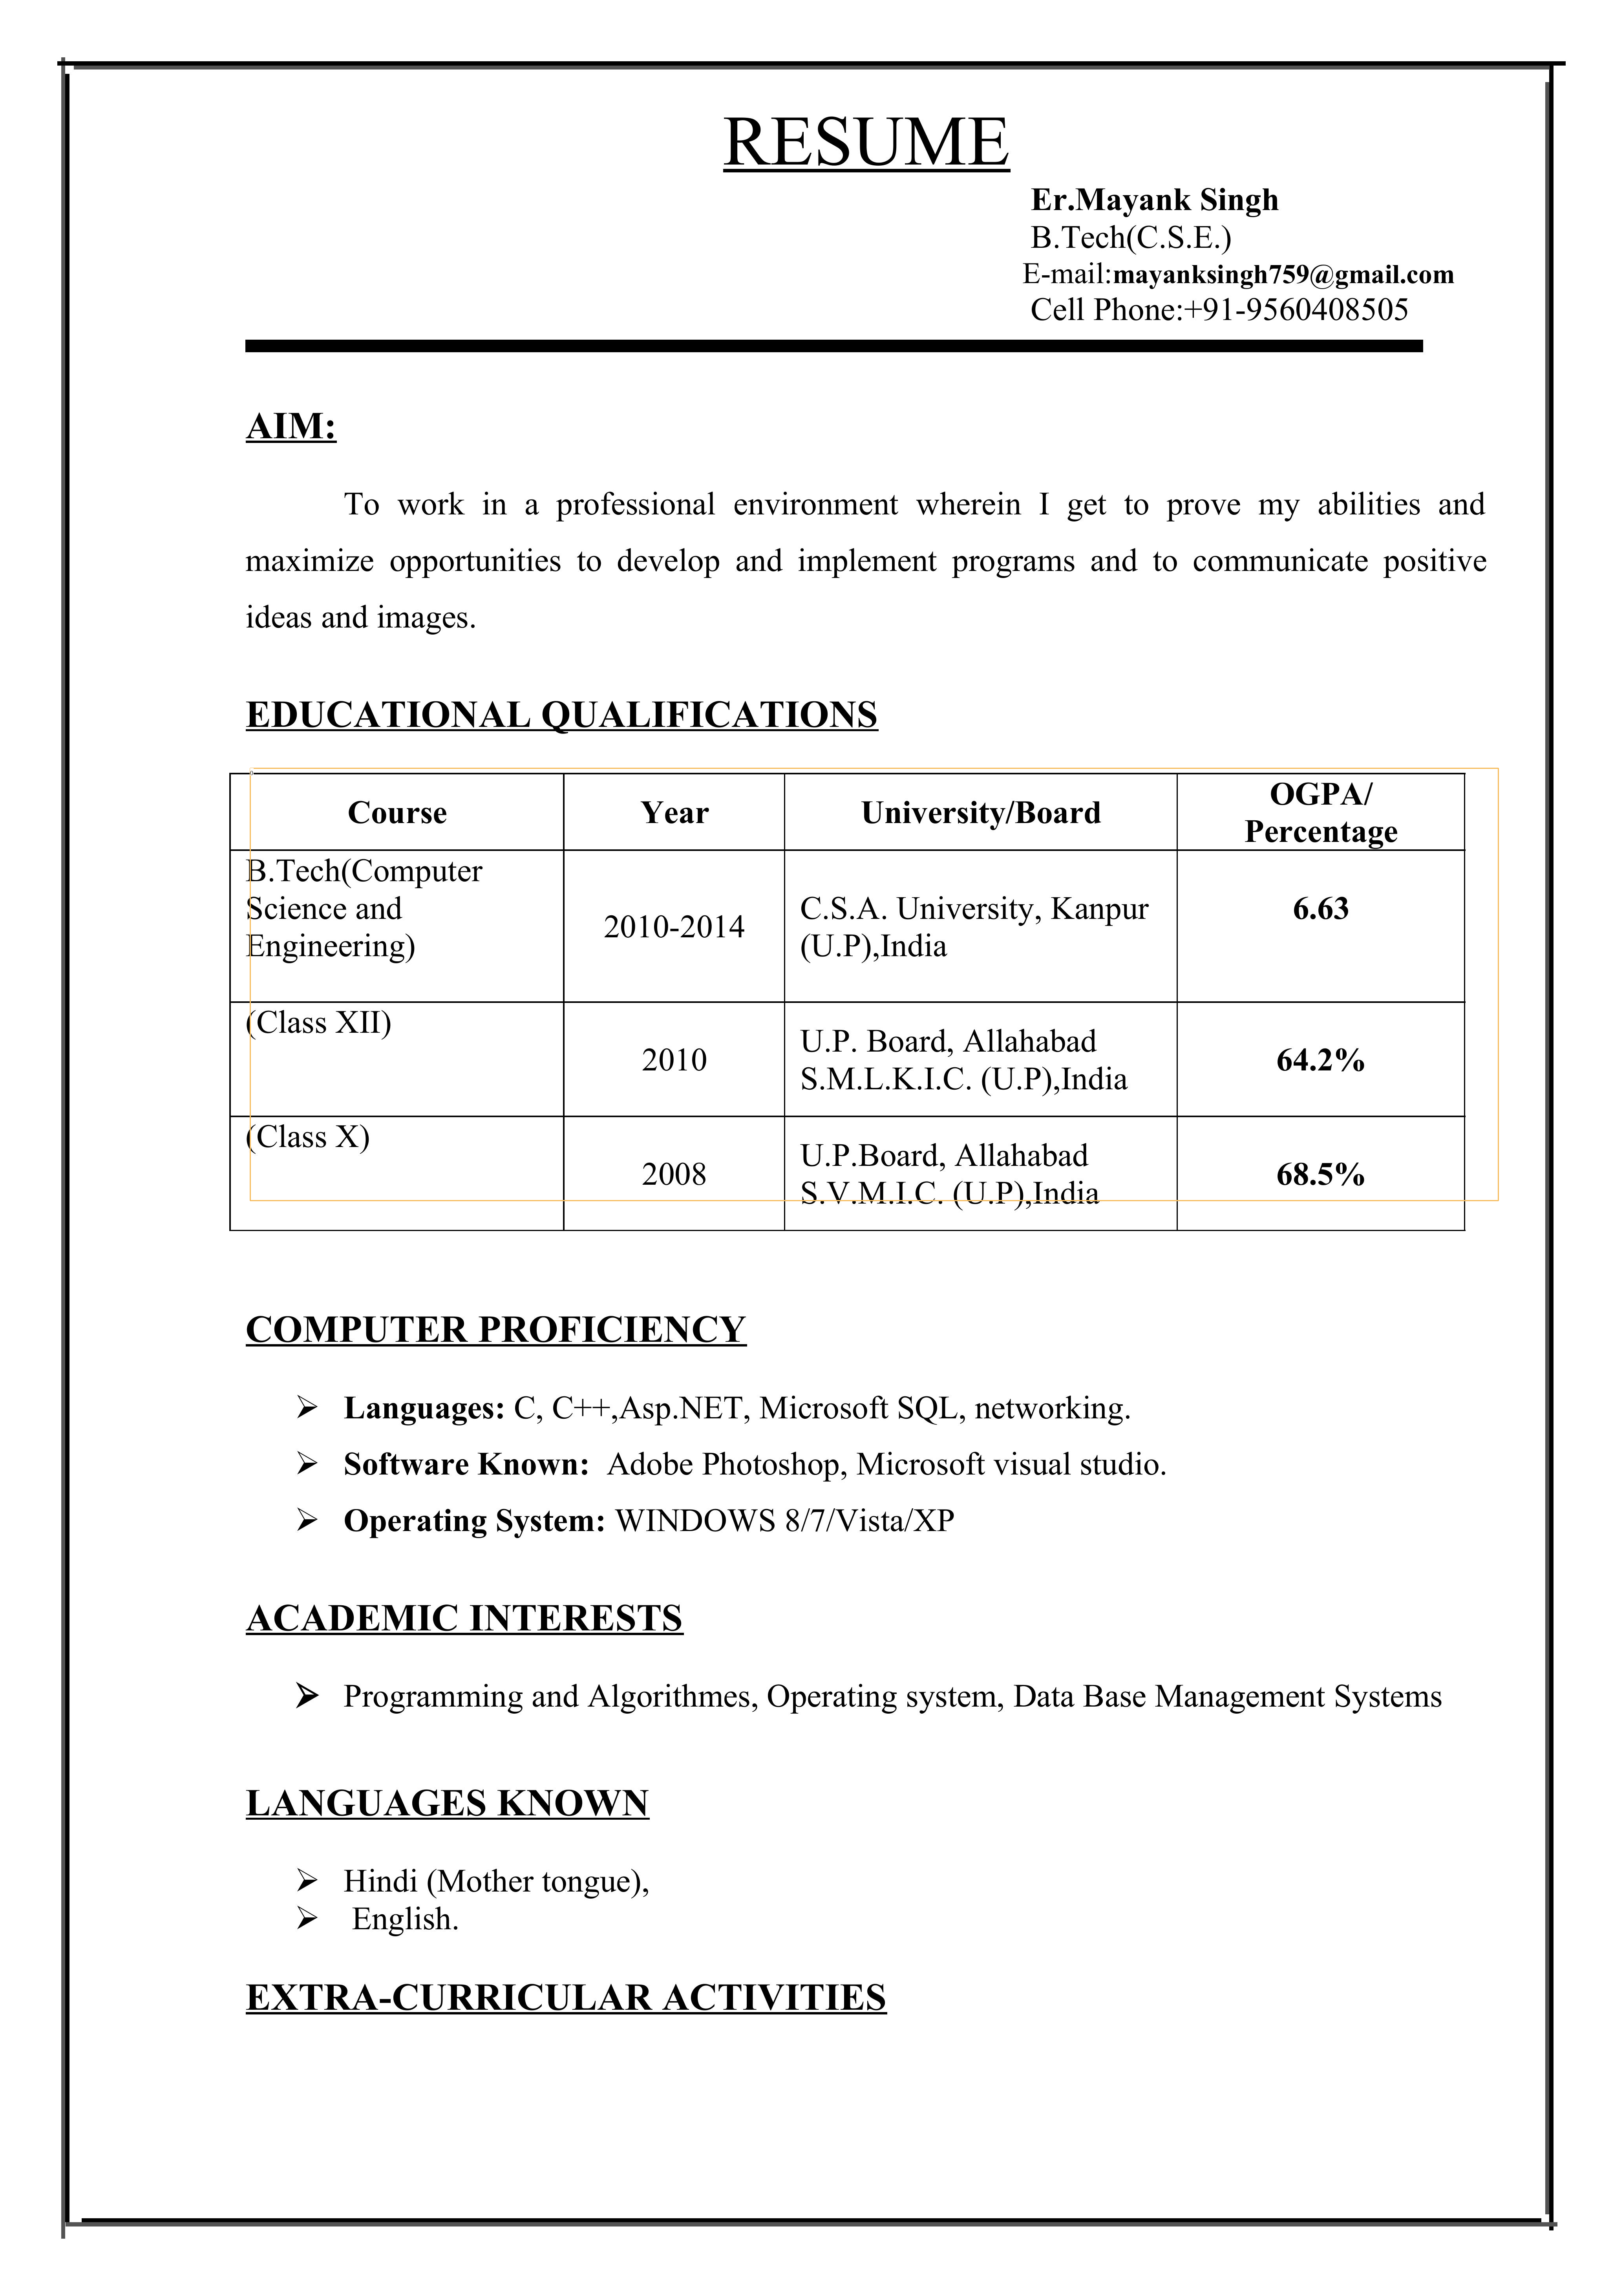

In [11]:
lp.draw_box(image, figure_blocks,
            box_width=3, 
            show_element_id=True)

In [12]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [13]:
for block in figure_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [14]:
for txt in figure_blocks.get_texts():
    print(txt, end='\n---\n')

Course Year University/Board GEA!
Percentage

B.Tech(Computer
Science and

C.S.A. University, Kanpur

 

Engineering) 2010-2014 (U.P), India

[Class 2A) U.P. Board, Allahabad
S.M.L.K.L.C. (U.P),India

(Class X)

U.P.Board, Allahabad

2008 SVMITIC (TJ P) India

68.5%

---


In [15]:
figure_blocks.get_texts()

['Course Year University/Board GEA!\nPercentage\n\nB.Tech(Computer\nScience and\n\nC.S.A. University, Kanpur\n\n \n\nEngineering) 2010-2014 (U.P), India\n\n[Class 2A) U.P. Board, Allahabad\nS.M.L.K.L.C. (U.P),India\n\n(Class X)\n\nU.P.Board, Allahabad\n\n2008 SVMITIC (TJ P) India\n\n68.5%\n\x0c']

In [16]:
for block in figure_blocks:
    print(block)

TextBlock(block=Rectangle(x_1=637.8055419921875, y_1=1956.4617919921875, x_2=3816.190673828125, y_2=3057.944091796875), text=Course Year University/Board GEA!
Percentage

B.Tech(Computer
Science and

C.S.A. University, Kanpur

 

Engineering) 2010-2014 (U.P), India

[Class 2A) U.P. Board, Allahabad
S.M.L.K.L.C. (U.P),India

(Class X)

U.P.Board, Allahabad

2008 SVMITIC (TJ P) India

68.5%
, id=None, type=TableRegion, parent=None, next=None, score=0.8479415774345398)


In [17]:
#!pip install spacy

#!pip install spacy-transformers
#!python -m spacy download en_core_web_trf

#!pip install spacy-transformers
#!python -m spacy download en_core_web_trf


In [18]:

import spacy
nlp = spacy.load("en_core_web_trf")

sentence=["".join(txt) for txt in figure_blocks.get_texts()]

".".join(sentence)

doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

Kanpur GPE
2010-2014 DATE
India GPE
U.P. Board ORG
Allahabad GPE
Allahabad GPE
2008 DATE
India GPE
68.5% PERCENT


/home/kguttas/anaconda3/envs/practica/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
